# **Machine Learning Group Project: Team 7**
# Project introduction

| Student Name | Student Number | Class Group |
| --- | --- | --- |
| **Alessandro Maugeri** | 53067 | TA |
| **Frank Andreas Bauer** | 53121 | TA |
|  **Johannes Rahn** | 53958 | TB |
| **Nicole Zoppi** | 53854 | TB |
| **Yannick von der Heyden** | 53629 | TA |



- **Course & Course Code:** Machine Learning (2487)
- **Instructors:** Qiwei Han & Alessandro Gambetti
- **Academic Year:** 2022/2023


This project was developed by Alessandro Alfio Maugeri, Frank Andreas Bauer, Johannes Rahn, Nicole Zoppi, and Yannick von der Heyden as part of Nova SBE's Machine Learning course taught during Semester 2 of the 2022/2023 academic year by Qiwei Han and Alessandro Gambetti. The purpose of the group work is to develop an end-to-end Machine Learning project with data of our choice, clearly highlighting the business use for our model.

The project exploits data from two distinct Kaggle pages ("Game Recommendations on Steam" and "Steam Store Games (Clean dataset)") which contain data on content published to the **Steam libary** (e.g. games and DLCs) and user-generated content associated with it (e.g. whether a review is positive or not, what general consensus is, how many people found the review useful, etc.). The final work merges data from 4 distinct CSV files and 1 JSON, all of which can be found in the data folder and all of whose contents are covered in detail in the current Notebook.

The objective is to develop a Machine Learning pipeline from beginning to end whose output has a clear, pertinent, and useful business use. In this project, we explore multiple models in order to identify the one which is best-suited for **predicting whether a given Steam user will enjoy a game or not**. This should allow Steam to optimize its service by tailoring it to individual clients and fine-tuning their recommender systems.

To guarantee a better computing perfomance, we split the project steps into 3 distinct Notebooks, meant to be run in succession. 

1. **a_csv_creation**. The current notebook presents the outline of the projects and reads data from the various datasets used, merging them into a final one (final_df) used for the following Notebooks.
2. **b_recommender_system**. The purpose of this notebook is to extract content-based similarities across different products on the basis of the plethora of of textual data contained in descriptive columns such as tags, genres, description, or steamspy_tags. These findings can later be utilized when building other models.
3. **c_data_exploration** TO ADD

---- 
Make sure to **only run this notebook once the previous notebooks [a_csv_creation.ipynb](a_csv_creation.ipynb) and [b_recommender_system.ipynb](b_recommender_system.ipynb) have been run at least once.** 

If those notebooks have both been run at least once, the kernel may be restarted before running this in order to obtain better performance and vaster machine memory.

## Importing Packages 

In [8]:
import ast
import csv
import datetime
import warnings
import scipy
import pandas as pd
import numpy as np
from datetime import datetime
from kneed import KneeLocator
from category_encoders import TargetEncoder

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# From sklearn
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer, mean_squared_error
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder, KBinsDiscretizer, OrdinalEncoder
from sklearn.preprocessing import PolynomialFeatures


# From imblearn
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imPipeline

# From scipy
from scipy.stats import chi2_contingency, pointbiserialr

## Reading DataFrame

In [9]:
# Optimizing datatypes for efficient DF storage
data_types = {
    'review_id': 'int32',
    'y': 'bool',
    'funny': 'int16',
    'helpful': 'int16',
    'app_id': 'int32',
    'title': 'string',
    'rating': 'category',
    'positive_ratio': 'int16',
    'user_reviews': 'int32',
    'win': 'bool',
    'mac': 'bool',
    'linux': 'bool',
    'price_final': 'float32',
    'price_original': 'float32',
    'discount': 'float32',
    'description': 'string',
    'tags': 'string',
    'english': 'int8',
    'developer': 'category',
    'publisher': 'category',
    'required_age': 'int8',
    'genres': 'string',
    'steamspy_tags': 'string',
    'achievements': 'int16',
    'average_playtime': 'int32',
    'median_playtime': 'int32',
    'owners': 'category',
    'steam_deck': 'bool',
    'user_id': 'int32',
    'products': 'int16',
    'reviews': 'int16',
    'hours': 'float32',
    'categories': 'string'
}

In [10]:
# Import the final DataFrame
final_df = pd.read_csv("data/final_df.csv",
                       dtype=data_types, parse_dates=['date', 'date_release'])

# Import the Textual Data
textual_df = pd.read_csv("data/textual_data.csv", index_col = "app_id")

In [11]:
# Rearrange Columns
final_df = final_df.reindex(columns = ["review_id", "y", "date", "funny", "helpful",
                                       "app_id", "title", "date_release", "rating", 
                                       "positive_ratio", "user_reviews", "win", "mac", "linux", 
                                       "price_final", "price_original", "discount", "description",
                                       "tags", 'english', 'developer', 'publisher', 'required_age', 
                                       'genres', 'steamspy_tags','achievements', 'average_playtime', 
                                       'median_playtime', "owners", "steam_deck",
                                       "user_id", "products", "reviews", "hours"])

# Sort by Review ID
final_df.sort_values(by=["review_id"], inplace = True)

## Stratified Resampling

The code below performs stratified sampling on the dataset. We do not have the computing power to run all our models on the complete set. Consequently, we provide the possibility of sampling the data down to 100,000 (minimum sample), 500,000 (medium sample), or 1,000,000 (medium-high) sample, should the computing power be sufficient. The data is stratified according to the target variable so as to prevent the further loss of negative feedback, which is already a strong minority in the set, as will be shown later in the notebook.

Alternatively, by skipping the lines of code below one can use the complete dataset with 6,564,923 observations. This naturally requires the appropriate computing power. **Due to our limited computing power, we will be running the entire notebook on 500,000 observations.**

In [6]:
n_total_samples = 100000
#n_total_samples = 500000
#n_total_samples = 1000000

In [20]:
# Find Negative-Positive Ratio
neg_pos_ratio = final_df['y'].value_counts()[1] / final_df['y'].value_counts()[0]

# Determine Number of False and Number of True Samples
n_false_samples = int(n_total_samples * neg_pos_ratio)
n_true_samples = n_total_samples - n_false_samples

# Sample On this Basis 
false_samples = final_df[final_df['y'] == False].sample(n_false_samples, random_state=70)
true_samples = final_df[final_df['y'] == True].sample(n_true_samples, random_state=70)

final_df = pd.concat([false_samples, true_samples])

# shuffle the data
final_df = final_df.sample(frac=1, random_state=70)

**EXPLANATION NEEDED FOR HANDLING OF TEXTUAL DATA FRANK**

We remove textual from dataframe given that they are in textual_df, but we create dummy for genres

In [36]:
# Create Dummy Columns for Genres
genres_dummies = final_df['genres'].str.get_dummies(sep=';')
final_df = pd.concat([final_df, genres_dummies], axis=1)

# Optimize Memory Usage
for elem in genres_dummies.columns:
    final_df[elem] = final_df[elem].astype("int16")

# Drop Tags, SteamSpy Tags, Description, Genres (as Single-Column List)
final_df.drop(["tags", "steamspy_tags", "description", "genres"], 
              axis = 1, inplace = True)

**EXPLANATION FOR HANDLING OF REVIEW-RELATED DATA**

We drop all the data inherently describing reviews because they cannot be used as inputs for the models (it is data collected after the acquisition of a game)

In [37]:
# Drop Tags, SteamSpy Tags, Description, Genres (as Single-Column List)
final_df.drop(['review_id', 'funny', 'helpful'], 
              axis = 1, inplace = True)

## Data Exploration

#### General Analysis

**VERY HIGH-LEVEL DATA EXPLORATION FIRST**

E.G. AMOUNT OF DIFFERENT FEATURES, COLUMN NAMES

IMPORTANT TO SAY: WE DEFINE IN DETAIL WHAT EACH COLUMN MEANS IN THE FINAL_DF_PREP NOTEBOOK. SO IF SOME LABELS ARE UNCLEAR, REFER TO THAT.

In [47]:
column_list = final_df.columns.tolist()
print(column_list)

['review_id', 'date', 'funny', 'helpful', 'app_id', 'title', 'date_release', 'rating', 'positive_ratio', 'user_reviews', 'win', 'mac', 'linux', 'price_final', 'price_original', 'discount', 'english', 'developer', 'publisher', 'required_age', 'genres', 'achievements', 'average_playtime', 'median_playtime', 'owners', 'steam_deck', 'user_id', 'products', 'reviews', 'hours', 'y', 'Action', 'Adventure', 'Animation & Modeling', 'Casual', 'Design & Illustration', 'Early Access', 'Free to Play', 'Gore', 'Indie', 'Massively Multiplayer', 'Nudity', 'RPG', 'Racing', 'Sexual Content', 'Simulation', 'Sports', 'Strategy', 'Utilities', 'Violent', 'Web Publishing']


In [10]:
print(len(column_list))

54


In [12]:
final_df.dtypes

review_id                         int32
y                                  bool
date                     datetime64[ns]
funny                             int16
helpful                           int16
app_id                            int32
title                    string[python]
date_release             datetime64[ns]
rating                         category
positive_ratio                    int16
user_reviews                      int32
win                                bool
mac                                bool
linux                              bool
price_final                     float32
price_original                  float32
discount                        float32
description              string[python]
tags                     string[python]
english                            int8
developer                      category
publisher                      category
required_age                       int8
genres                   string[python]
steamspy_tags            string[python]


#### Target Variable Exploration

First we explore the distribution of our target variable _y_, which is a column of booleans which signal whether a given user would recommend a given game or not.

In creating a countplot, we find that the dataset is rather unbalanced. Only 14.12% of observations is negative, while the remaining 85.88% is positive. This will certainly be kept in consideration when training our model, as the unbalance must be offset. With a quick calculation, we find that the ratio of positives to negatives is 6.08 approximately.

<Figure size 720x360 with 0 Axes>

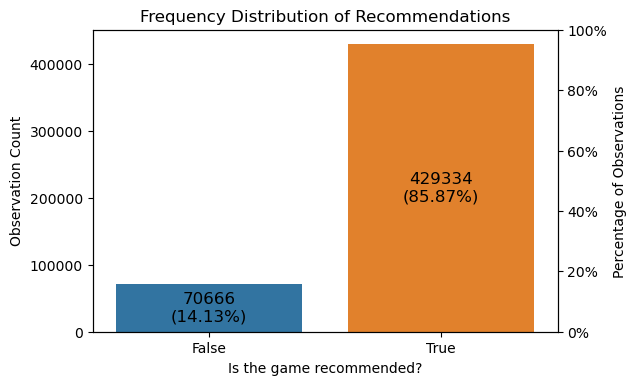

In [7]:
# Plotting the frequency distribution of number of recommendations
plt.figure(figsize=(10, 5))
plt.figure(dpi=100)

ax = sns.countplot(x='y', data=final_df)

plt.title('Frequency Distribution of Recommendations')
plt.xlabel('Is the game recommended?')
plt.ylabel('Observation Count')

# Calculate percentage of each category
percentages = final_df['y'].value_counts(normalize=True) * 100

# Annotate the bars with counts and percentages
for p in ax.patches:
    count = int(p.get_height())
    percentage = percentages.sort_values()[int(p.get_x() + p.get_x())]
    ax.annotate(f'{count}\n({percentage:.2f}%)', 
                (p.get_x() + p.get_width() / 2., p.get_height() / 2),
                ha='center', va='center', fontsize=12, color='black')

# Add percentage axis
ax2 = ax.twinx()
ax2.set_ylim(0, 100)
ax2.set_ylabel('Percentage of Observations')
ax2.yaxis.set_major_formatter(mtick.PercentFormatter())

plt.show()

In [18]:
print("The \033[1mratio of positive to negative recommendations\033[0m is", 
     final_df['y'].value_counts()[0] / final_df['y'].value_counts()[1])

The ratio of positive to negative recommendations is 6.084492603012321


#### Steam Rating Exploration

Reamining within the realm of ratings, we explore the distribution of the Steam rating system through a frequency table. Very interestingly, we observe that many of the rating categories are not in fact present in our data. It would seem that there are no games with overall negative reviews, while most games either have a _Very Positive_ or _Overwhelmingly Positive_ rating (appr. 86.24%). All in all, this is in line with the previous observation concerning the unbalanced dataset. 

Another noteworthy aspect of the dataset is that there are no _Positive_ reviews. The remaining 13.76% is split between _Mostly Positive_ and _Mixed_, with the former counting more observation than the latter. It is worth remembering that the Steam rating system assigns the _Positive_ rating to games that seem to have good ratings, but a review count which is not high enough to really "consacrate" its status as a very positively (or overwhlemingly positively) rated game. This perhaps informs us on the type of game which tends to be included in these datasets, focusing on larger more "mainstream" products rather than smaller lesser-known ones.

In [24]:
# Create a frequency table
rating_counts = pd.DataFrame(final_df['rating'].value_counts())

# Rename the columns
rating_counts.columns = ['Observation Count']

# Sort the rows based on the order of rating categories
rating_order = ["Overwhelmingly Positive", "Very Positive", "Positive", 
                "Mostly Positive", "Mixed", "Mostly Negative", 
                "Negative", "Very Negative", "Overwhelmingly Negative"]

rating_counts = rating_counts.reindex(rating_order)

# Fill NaN with 0
rating_counts.fillna(0, inplace = True)

# Add a column for percentage of observations
rating_counts['Percentage of Observations'] = rating_counts['Observation Count'] / len(final_df) * 100

# Format the percentage column
rating_counts['Percentage of Observations'] = rating_counts['Percentage of Observations'].map('{:.2f}%'.format)

# Turn to Integer
rating_counts["Observation Count"] = [int(i) for i in rating_counts["Observation Count"]]

display(rating_counts)

,Observation Count,Percentage of Observations
rating,,
Overwhelmingly Positive,23255,23.25%
Very Positive,62738,62.74%
Positive,0,0.00%
Mostly Positive,11689,11.69%
Mixed,2318,2.32%
Mostly Negative,0,0.00%
Negative,0,0.00%
Very Negative,0,0.00%
Overwhelmingly Negative,0,0.00%


#### Owners Exploration

We plot the ownership data, which is currently subdivided in categorical strings which simply describe the range of users which any given game has. For the purposes of our model, this will clearly have to be transformed through some form of ordinal encoding. We look at the distribution of these games to gain actionable insights on how data is distributed across these categories, and whether some of these categories can be "condensed" together. This may simplify our eventual model and has the added benefit of ironing out categories which may contain a number of observations far too small compared to other categories. The implication here being that if the data were too unbalanced, it would become more difficult for an eventual regression to truly establish clear statistically significant links.


CHOOSE ONE OF THE PLOTS BELOW AND EXPAND ON IT.

<Figure size 720x360 with 0 Axes>

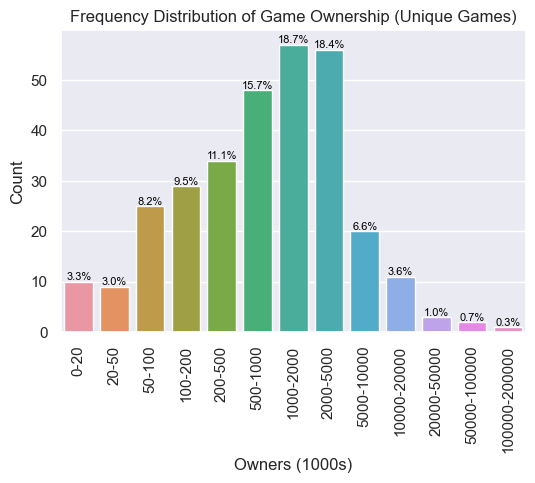

In [11]:
# Drop duplicates based on app_id
final_df = final_df.drop_duplicates(subset=['app_id'])

# Create Order
order_list = ["0-20", "20-50", "50-100", "100-200", "200-500",
              "500-1000", "1000-2000", "2000-5000", "5000-10000",
              "10000-20000", "20000-50000", "50000-100000", 
              "100000-200000"]

# Plotting the frequency distribution of number of recommendations
sns.set_theme()
plt.figure(figsize=(10, 5))
plt.figure(dpi=100)
plt.xticks(rotation=90)

ax = sns.countplot(x='owners', data=final_df,
                  order = order_list)

# Add percentages to plot
total = len(final_df)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total)
    x = p.get_x() + p.get_width() / 2
    y = p.get_y() + p.get_height() + (total/1000)
    ax.annotate(percentage, (x, y), ha='center', fontsize=8, color='black')
    
# Add axis labels and title
plt.xlabel('Owners (1000s)')
plt.ylabel('Count')
plt.title('Frequency Distribution of Game Ownership (Unique Games)')

plt.show()

<Figure size 720x360 with 0 Axes>

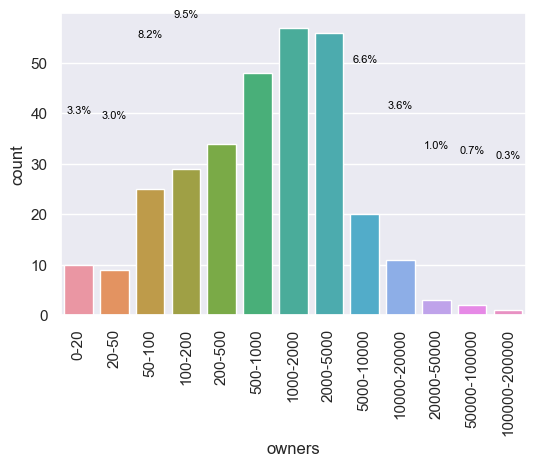

In [12]:
# Create Order
order_list = ["0-20", "20-50", "50-100", "100-200", "200-500",
              "500-1000", "1000-2000", "2000-5000", "5000-10000",
              "10000-20000", "20000-50000", "50000-100000", 
              "100000-200000"]

# Plotting the frequency distribution of number of recommendations
sns.set_theme()
plt.figure(figsize=(10, 5))
plt.figure(dpi=100)
plt.xticks(rotation=90)

ax = sns.countplot(x='owners', data=final_df,
                  order = order_list)

# Add percentages to plot
total = len(final_df)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total)
    x = p.get_x() + p.get_width() / 2
    y = p.get_y() + p.get_height() + 30
    ax.annotate(percentage, (x, y), ha='center', fontsize=8, color='black')
    
plt.show()

#### Discount Rates

Given that discounts are part of the sales process, we attempt to establish whether the _discount_ column contains a satisfactory range of values which may allow us to appropriately enhance the model (or perhaps construct some form of additional model to predict offered discount). 

The results here are rather disappointing due to the limited range of unique values which this column takes (11), which almost makes it more of a discrete variable than continuous one. Furthermore, only discounts above 50% were retained in this dataset and they are a very large minority compared to games which were purchased at full price.

It would seem that the rich range of possible discounts which were found to exist in [a_csv_creation.ipynb](a_csv_creation.ipynb) were lost in the merging process, particularly when merging the recommendations dataset. This is problematic given that the dataframe is the only truly indispensible one for our model, therefore we cannot run any join that would force games into the dataframe which it does not contain any data for. In that case, we would be foregoing the game-user pairing which is intrinsicially necessary to building our analysis. We do not believe building a model based on the games.csv alone would be useful, as discounts on these platforms are not solely based on game characteristics, but also whether a user is deemed to a good fit for a certain special offer. 

Given these considerations, we will later build a rule-based discount determiner as opposed to a fully automated machine-learning algorithm.

In [13]:
print("Number of Unique Values in discount column:", len(final_df["discount"].value_counts()))

Number of Unique Values in discount column: 11


In [22]:
discount_count = final_df["discount"].value_counts()
discount_perc = final_df["discount"].value_counts(normalize=True) * 100
discount_df = pd.DataFrame({'Discount Count': discount_count, 'Discount Percentage': discount_perc})
discount_df.index = [f'{round(i, 2)}%' for i in discount_df.index]
discount_df.sort_index(ascending=True, inplace=True)
discount_df.T

,0.0%,50.0%,60.0%,65.0%,66.0%,67.0%,75.0%,80.0%,84.0%,85.0%,90.0%
Discount Count,94171.000,435.000,1100.0,208.000,304.000,112.000,1618.000,538.000,107.000,134.000,1273.000
Discount Percentage,94.171,0.435,1.1,0.208,0.304,0.112,1.618,0.538,0.107,0.134,1.273


**Boxplot of Final Prices**

The Boxplot provides us with a visual summary of the distribution of the final prices in the dataset. It shows the median, lower quartile, upper quartile, and any potential outliers in the data. This helps us to understand the range and spread of the final prices, which can provide insights into pricing strategies or market conditions.

It also helps us to identify potential outliers in the data. Those outliers may indicate errors, unusual pricing patterns, or unique market conditions. Identifying these outliers can help you better understand the data and decide how to handle them in further analysis.

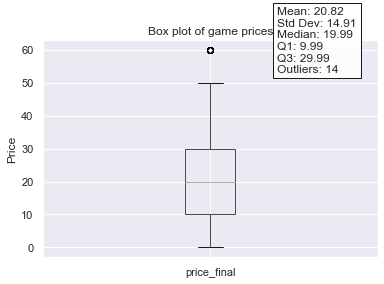

In [16]:
# boxplot of final price

ax = final_df.boxplot('price_final')

ax.set_ylabel('Price')
ax.set_title('Box plot of game prices')

stats = final_df['price_final'].describe()
mean = final_df['price_final'].mean()
std_dev = final_df['price_final'].std()

# calculate outliers
q1 = stats['25%']
q3 = stats['75%']
iqr = q3 - q1
lower_bound = q1 - (1.5 * iqr)
upper_bound = q3 + (1.5 * iqr)

outliers = final_df[(final_df['price_final'] < lower_bound) | (final_df['price_final'] > upper_bound)]['price_final']
num_outliers = outliers.count()

# add statistics to the plot
ax.text(0.7, 0.85, f"Mean: {mean:.2f}\nStd Dev: {std_dev:.2f}\nMedian: {stats['50%']:.2f}\nQ1: {stats['25%']:.2f}\nQ3: {stats['75%']:.2f}\nOutliers: {num_outliers}",
        transform=ax.transAxes, bbox=dict(facecolor='white', edgecolor='black', alpha=0.9))


plt.show()


The mean (average) of the data is 21.32, which means that the typical value in the dataset is around 21.32.
The median (middle value) is 19.99, which suggests that half of the data points are below 19.99 and half are above it. Since the mean and median are close to each other, this implies that the data distribution might be roughly symmetrical.

The standard deviation (Std. Dev.) is 16.95, indicating that the data points are spread out over a range of approximately 16.95 units from the mean. A larger standard deviation suggests greater variability in the dataset.

The first quartile (Q1) is 7.99, which means that 25% of the data points are below 7.99.
The third quartile (Q3) is 29.99, indicating that 75% of the data points are below 29.99.
The interquartile range (IQR), which represents the range of the middle 50% of the data, can be calculated as Q3 - Q1 = 29.99 - 7.99 = 22. This suggests that the middle 50% of the data points have a spread of 22 units.

There are no outliers in this dataset, which means that all data points fall within a reasonable range and there are no extreme values that could potentially skew the interpretation.

**Exploration of game developers**

In this section we explore the top 10 developers (number of games published and rating). It is important to note that developers can match or be different from publishers.

In [ ]:
# Count the number of unique games released by each developer
developer_counts = final_df.groupby('developer')['title'].nunique()

# Sort the developers by the number of unique games in descending order and get the top 10
top_10_developers = developer_counts.sort_values(ascending=False).head(10)

# Print the top 10 developers
print(top_10_developers)

developer
Valve                         6
Bethesda Game Studios         6
KOEI TECMO GAMES CO., LTD.    4
Spike Chunsoft Co., Ltd.      4
CAPCOM Co., Ltd.              4
Paradox Development Studio    4
Square Enix                   3
Obsidian Entertainment        3
Treyarch                      3
Capcom                        3
Name: title, dtype: int64

In [18]:
unique_games = final_df['title'].nunique()
print(f"Number of unique games: {unique_games}")

Number of unique games: 305


In [19]:
unique_developers = final_df['developer'].nunique()
print(f"Number of unique developers: {unique_developers}")


Number of unique developers: 253


In [20]:
# Calculate the average positive rating for each developer
average_positive_ratings = final_df.groupby('developer')['positive_ratio'].mean()

# Sort the developers by the average positive rating in descending order and get the top 10
top_10_developers_positive_ratings = average_positive_ratings.sort_values(ascending=False).head(10)

# Print the top 10 developers with the best average positive ratings
print(top_10_developers_positive_ratings)


developer
ConcernedApe       98.0
Kristjan Skutta    98.0
Ludeon Studios     98.0
Mega Crit Games    97.0
Team Cherry        97.0
Petroglyph         97.0
BeamNG             97.0
Ninja Kiwi         97.0
Nicalis, Inc.      97.0
Doborog Games      97.0
Name: positive_ratio, dtype: float64


**Exploration of game publishers**

Similar to the developers, we also investigate the top 10 game publishers.

In [21]:
# Count the number of unique games released by each developer
publisher_counts = final_df.groupby('publisher')['title'].nunique()

# Sort the developers by the number of unique games in descending order and get the top 10
top_10_publishers = publisher_counts.sort_values(ascending=False).head(10)

# Print the top 10 developers
print(top_10_publishers)

publisher
Ubisoft                       11
Valve                         10
Bethesda Softworks            10
SEGA                           8
Paradox Interactive            8
Spike Chunsoft Co., Ltd.       8
BANDAI NAMCO Entertainment     6
KOEI TECMO GAMES CO., LTD.     6
Activision                     5
Square Enix                    5
Name: title, dtype: int64


In [22]:
unique_publishers = final_df['publisher'].nunique()
print(f"Number of unique publishers: {unique_publishers}")


Number of unique publishers: 198


**Relationship between Products Owned and Number of Reviews**

Looking at the relationship between products owned and the number of reviews can give insight into user engagement with a product. If a product has a high number of reviews relative to the number of products owned, it suggests that users are more actively engaged with the product and may have strong opinions about it. This also gives an indication about the popularity of a product. If a product has a high number of products owned but a low number of reviews, it may suggest that the product is popular but users are less likely to leave reviews.

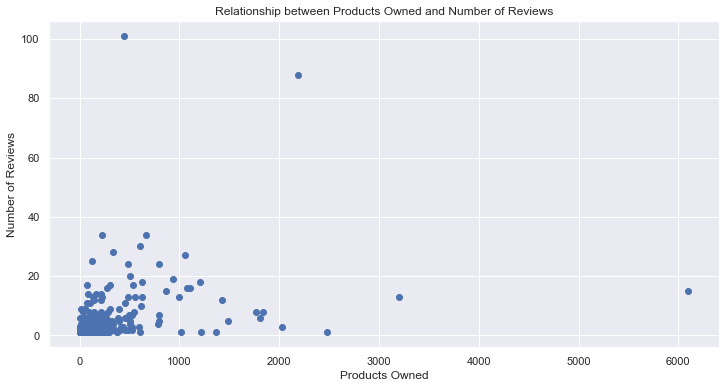

Correlation coefficient between Products Owned and Number of Reviews: 0.32


In [23]:
plt.figure(figsize=(12, 6))
plt.scatter(final_df['products'], final_df['reviews'])
plt.xlabel('Products Owned')
plt.ylabel('Number of Reviews')
plt.title('Relationship between Products Owned and Number of Reviews')
plt.show()

correlation = final_df['products'].corr(final_df['reviews'])
print(f"Correlation coefficient between Products Owned and Number of Reviews: {correlation:.2f}")

The plot shows that users are more likely to leave a review when they own fewer products.

There could be a few reasons for this:

- Selection bias: People who own fewer products may be more passionate or invested in those products and therefore more likely to leave a review. They may have had a stronger emotional connection to the product or found it to be more impactful on their lives.
- Time constraints: People who own more products may have less time to leave a review for each product they own, whereas those who own fewer products may have more time to leave reviews.
- Product quality: People who own fewer products may be more discerning in their purchases and therefore more likely to leave a review to share their experience with others. They may also have higher expectations for the products they purchase, making them more likely to leave a review if the product meets or exceeds those expectations.
- Product type: It's possible that certain types of products, such as luxury items or niche products, are more likely to be reviewed by people who own fewer products. These products may be more novel or unique, leading to a higher likelihood of leaving a review.

**Compatibility of Windows, Mac and Linux**

Analyzing the compatibility between different operating systems helps us to understand the market distribution of each platform. Each operating system has a different market share, and understanding the distribution can inform developers about potential target audiences and which platforms are more popular among users. Different user groups may have preferences for specific platforms due to factors such as available software, hardware compatibility, or personal taste. Analyzing compatibility can also help to identify patterns or trends in user preferences and behavior across different platforms. In addition, compatibility data can provide insights into which platforms have higher demand or user base, helping developers make informed decisions.

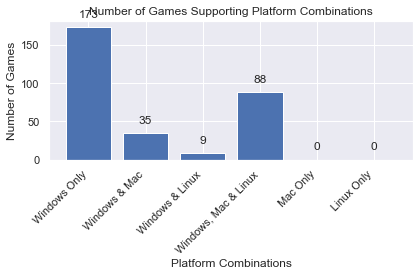

In [26]:
# Calculate the number of games supporting each combination of platforms (windows, mac, linux)

win_only = ((final_df['win'] == True) & (final_df['mac'] == False) & (final_df['linux'] == False)).sum()
win_mac = ((final_df['win'] == True) & (final_df['mac'] == True) & (final_df['linux'] == False)).sum()
win_linux = ((final_df['win'] == True) & (final_df['mac'] == False) & (final_df['linux'] == True)).sum()
win_mac_linux = ((final_df['win'] == True) & (final_df['mac'] == True) & (final_df['linux'] == True)).sum()
mac_only = ((final_df['win'] == False) & (final_df['mac'] == True) & (final_df['linux'] == False)).sum()
linux_only = ((final_df['win'] == False) & (final_df['mac'] == False) & (final_df['linux'] == True)).sum()

# Platform combinations and their counts

platform_combinations = {
    "Windows Only": win_only,
    "Windows & Mac": win_mac,
    "Windows & Linux": win_linux,
    "Windows, Mac & Linux": win_mac_linux,
    "Mac Only": mac_only,
    "Linux Only": linux_only,
}

fig, ax = plt.subplots()
ax.bar(platform_combinations.keys(), platform_combinations.values())

# Add the counts above the bars
for i, (combination, count) in enumerate(platform_combinations.items()):
    ax.text(i, count + 10, f"{count}", ha='center', va='bottom')

ax.set_title("Number of Games Supporting Platform Combinations")
ax.set_xlabel("Platform Combinations")
ax.set_ylabel("Number of Games")

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Windows definitly dominates, when it comes to the number of games it supports. Most developers only develop for windows. However, there are still many games which run on windows, mac and linux. These results tell us that we should consider a users operating system, when recommending a game based on a user_id.

**Trends in game releases, user reviews, and ratings over time**

Analyzing these trends helps us to identify patterns in the gaming industry, such as seasonal variations in game releases and user reviews. Understanding these patterns can help stakeholders make informed decisions and tailor their strategies accordingly. Examining user ratings over time can help us to identify any patterns or changes in user sentiment which is important to understand if the general perception of a product or service is improving, declining, or remaining stable.

Moreover, looking at the user reviews and ratings over time can provide us with insights into how user preferences change and evolve. This information can be valuable for game developers and publishers to adjust their products and marketing efforts to meet user demands and expectations better.

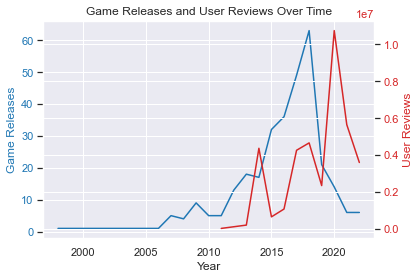

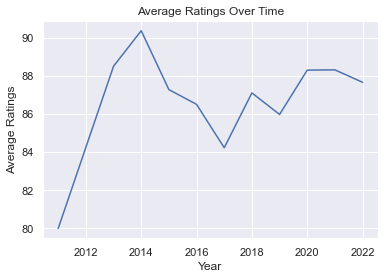

In [27]:
# Trends in game releases, user reviews, and ratings over time

final_df['date_release'] = pd.to_datetime(final_df['date_release'])
final_df['date'] = pd.to_datetime(final_df['date'])

game_releases_by_year = final_df.groupby(final_df['date_release'].dt.year).size()
user_reviews_by_year = final_df.groupby(final_df['date'].dt.year)['user_reviews'].sum()
avg_ratings_by_year = final_df.groupby(final_df['date'].dt.year)['positive_ratio'].mean()

fig, ax1 = plt.subplots()

ax1.set_xlabel('Year')
ax1.set_ylabel('Game Releases', color='tab:blue')
ax1.plot(game_releases_by_year.index, game_releases_by_year, color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('User Reviews', color='tab:red')
ax2.plot(user_reviews_by_year.index, user_reviews_by_year, color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

fig.tight_layout()
plt.title('Game Releases and User Reviews Over Time')
plt.show()

plt.plot(avg_ratings_by_year.index, avg_ratings_by_year)
plt.xlabel('Year')
plt.ylabel('Average Ratings')
plt.title('Average Ratings Over Time')
plt.show()

On average, the number of game releases has increased from 2006 to 2022. There where several drop in 2013, 2018 and 2020. The last drop is most likely due to the Covid-19 pandemic. User started reviewing games since 2010. The number of reviews has strongly increased since then.

The average ratings over time have decreased from 93 in the year 2010 to 84 in 2018. Later it increased again to a rating of 84 in the year 2022. 

These results could be due to the following reasons:

Game Releases: The plot shows an increase in the number of game releases from 2006 to 2022. 
This could be attributed to several factors such as:
- Growing popularity of gaming: As gaming continues to gain popularity as a form of entertainment, more game developers are entering the market, leading to an increase in the number of game releases.
- Ease of developing and distributing games: With the rise of digital distribution platforms, it has become easier for game developers to develop and distribute games, which has led to an increase in the number of game releases.
- Advances in technology: The increasing availability of advanced game engines, tools, and resources has made it easier for game developers to create and release games.

User Reviews: The plot shows an increase in the number of user reviews since 2010. 
This could be attributed to several factors such as:
- Rise of online platforms: The rise of online platforms such as Steam, GOG, and Itch.io has made it easier for users to share their experiences and opinions on games.
- Social media: The increasing use of social media has made it easier for users to connect with each other and share their experiences with games, leading to an increase in user reviews.
- Importance of user feedback: Game developers have increasingly recognized the importance of user feedback in improving the quality of games, leading to an increase in the number of user reviews.

Average Ratings: The plot shows a decrease in average ratings from 2010 to 2018, followed by an increase in ratings from 2018 to 2022. 
This could be attributed to several factors such as:
- Increased competition: With more games being released every year, there is increased competition among game developers to produce high-quality games, which could have led to a decline in average ratings from 2010 to 2018.
- Changing user preferences: User preferences for games may have changed over time, leading to a decline in ratings for certain types of games.
- Increased focus on quality: Game developers may have focused more on improving the quality of their games in recent years, leading to an increase in average ratings from 2018 to 2022.

## Custom Pipeline Class Construction

### Feature Engineering

#### Elapsed Time
Here we construct the custom pipeline class ElapsedTimeTransformer, which creates a new feature called _elapsed_time_. This is the amount of time which has passed since a product's release date and the user purchasing it. This could be a proxy for how "into a product" a given user could be. The class takes the following arguments:
- **add_elapsed**: Receives a boolean to determine whether to create the new column. Deafult is True
- **drop_features**: Receives a boolean to determine whether to drop _date_ and _date_release_ columns after having created _add_elapsed_. These variables are not particularly useful for the regression so it may be worthwhile to remove them from the DataFrame. Default is True.

In [26]:
class ElapsedTimeTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, add_elapsed=True, drop_features=True):
        self.add_elapsed = add_elapsed
        self.drop_features = drop_features

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        if self.add_elapsed:
            X = X.copy()
            elapsed_time = (pd.to_datetime(X["date"]) - pd.to_datetime(X["date_release"])).dt.days
            X = X.assign(elapsed_time=elapsed_time)

        if self.drop_features:
            X = X.drop(['date', 'date_release'], axis=1)

        return X

#### Ordinally Encoded Steam Rating
Here we construct the custom pipeline class SteamRatingEncoder. Its purpose is to transform the Steam categorical ratings in the _rating_ column (whose meanings are better explained in a_csv_creation.ipynb) into an ordinally encoded feature. However, given that the categories follow a diverging pattern (where "Mixed" is a middle ground and games can have varying degrees of Positive or Negative feedback), we encode them as such. We give users the possibility of encoding them with a standard scale that goes from -4 to 4, or a slightly more weighted one which attempts to numerically translate the large difference between being simply "Mostly Positive" (or Negative) and being "Positive" (or Negative). The class has the following arguments:

- **drop_rating**: Receives a boolean to determine whether to drop the _rating_ categorical column. Deafult is True.
- **standard_diverging_scale**: Receives a boolean to determine whether to use the standard scale instead of the weighted one. Default is True.

In [27]:
class SteamRatingEncoder(BaseEstimator, TransformerMixin):
    
    def __init__(self, drop_rating=True, standard_diverging_scale=True):
        
        self.drop_rating = drop_rating
        self.standard_diverging_scale = standard_diverging_scale
        
        if standard_diverging_scale:
            self.rating_dict = {
                "Overwhelmingly Positive": 4,
                "Very Positive": 3,
                "Positive": 2,
                "Mostly Positive": 1,
                "Mixed": 0,
                "Mostly Negative": -1,
                "Negative": -2,
                "Very Negative": -3,
                "Overwhelmingly Negative": -4
            }
        else:
            self.rating_dict = {
                "Overwhelmingly Positive": 9,
                "Very Positive": 8,
                "Positive": 7,
                "Mostly Positive": 4,
                "Mixed": 0,
                "Mostly Negative": -4,
                "Negative": -7,
                "Very Negative": -8,
                "Overwhelmingly Negative": -9
            }
            
        self.drop_rating = drop_rating

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = X.copy()
        X['rating_encoded'] = X['rating'].map(self.rating_dict)
        if self.drop_rating:
            X = X.drop(['rating'], axis=1)
        return X

#### Tendency to Review
Here we construct the custom pipeline class TendencyToReview. Its purpose is to create a new feature _tendency_to_review_ which is the ratio between reviews by a user and number of products. It allows us to gauge how often a user leaves reviews. People tend to rarely leave reviews, as shown in the exploratory data analysis above. Consequently, the class standardises the resulting data. The arguments are the following:
- **drop_columns**: Receives a boolean to determine whether to drop _products_ column. Deafult is True.
- **standardize**: Receives a boolean to determine whether to standarsize the resulting data or not. Default is True.

In [28]:
class TendencyToReview(BaseEstimator, TransformerMixin):
    
    def __init__(self, drop_words=True, standardize=True):
        
        self.drop_words = drop_words
        self.standardize = standardize

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = X.copy()
        X["tendency_to_review"] = (X["reviews"]) / (X["products"])
        if self.drop_words:
            X = X.drop("products", axis=1)
        if self.standardize:
            scaler = StandardScaler()
            X["tendency_to_review"] = scaler.fit_transform(X[["tendency_to_review"]])
        return X

#### Developer and Distributor Metrics
Here we construct the custom pipeline class DevDisTransformer. Depending on the arguments which are passed to it, it can create up to three new features. It utilizes target encoding on both the developer and distributor columns and has gives the users the possibility to also create an interaction feature between these two variables. The idea is that there may be developers which tend to put out better games than others, or distributors which tend to pick up better games than others. Sometimes, it is the collaboration between a particular developer and distributor which creates true "videogaming gold". Consequently, we give the possibility of creating an interaction term. The class' arguments are the following:
- **y**: Receives the y values corresponding to the dataset being transformed. Needed for Target Encoding.
- **encode_dev**: Receives a boolean to determine whether to target encode the _developer_ column. Deafult is True.
- **encode_dis**: Receives a boolean to determine whether to target encode the _distributor_ column. Deafult is True.
- **drop_cols**: Receives a boolean to determine whether to drop the _developer_ and _distributor_ columns after the transformation. Default is True.
- **interaction**: Receives a boolean to determine whether to create interaction term or not. Default is True.

In [29]:
class TargetEncoderTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, y, encode_dev=True, encode_pub=True, drop_cols=True, interaction=True):
        self.encode_dev = encode_dev
        self.encode_pub = encode_pub
        self.drop_cols = drop_cols
        self.interaction = interaction
        self.y = y
        self.encoder_dev = TargetEncoder()
        self.encoder_pub = TargetEncoder()

    def fit(self, X, y=None):
        if self.encode_dev:
            self.encoder_dev.fit(X["developer"], self.y)
        if self.encode_pub:
            self.encoder_pub.fit(X["publisher"], self.y)
        return self

    def transform(self, X, y=None):
        X = X.copy()
        if self.encode_dev:
            X["targ_encode_dev"] = self.encoder_dev.transform(X["developer"])
        if self.encode_pub:
            X["targ_encode_pub"] = self.encoder_pub.transform(X["publisher"])
        if self.interaction:
            X["dev_pub_interaction"] = X["targ_encode_dev"] * X["targ_encode_pub"]
        if self.drop_cols:
            X.drop(columns=["developer", "publisher"], inplace=True)
        return X

In [30]:
class TargetEncoderTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, y, encode_dev=True, encode_pub=True, drop_cols=True, interaction=True):
        self.encode_dev = encode_dev
        self.encode_pub = encode_pub
        self.drop_cols = drop_cols
        self.interaction = interaction
        self.y = y
        self.encoder_dev = TargetEncoder()
        self.encoder_dis = TargetEncoder()

    def fit(self, X, y=None):
        if self.encode_dev:
            self.encoder_dev.fit(X_train["developer"].reset_index(drop = True), self.y.reset_index(drop = True))
        if self.encode_pub:
            self.encoder_dis.fit(X["publisher"].reset_index(drop = True), self.y.reset_index(drop = True))
        return self

    def transform(self, X, y=None):
        X = X.copy()
        if self.encode_dev:
            X["targ_encode_dev"] = self.encoder_dev.transform(X["developer"])
        if self.encode_pub:
            X["targ_encode_pub"] = self.encoder_dis.transform(X["publisher"])
        if self.interaction:
            X["dev_dis_interaction"] = X["targ_encode_dev"] * X["targ_encode_pub"]
        if self.drop_cols:
            X.drop(columns=["developer", "publisher"], inplace=True)
        return X


#### Genre Dummy Interactions

#### Developer and Distributor Metrics
Here we construct the custom pipeline class InteractionsTransformer. When called, it finds the maximum number of genre dummies which are positive across all rows. Based on what it finds, it calls a PolynomialFeatures with the approriate degree to capture every single interaction without making the features overly complex (e.g. by setting a higher degree than necessary to capture all interactions). The PolynomialFeatures only returns the interaction terms (no quadratic terms) and adds them to the DataFrame. This can be used for both the genre dummies and the OS dummies. The argument is only one:
- **columns:** Receives the columns with dummies. If not specified, the list of genres in our dataset is used.

In [31]:
class InteractionsTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, columns=None):
        if columns is None:
            columns = ['Action', 'Adventure', 'Animation & Modeling', 'Casual',
                       'Design & Illustration', 'Early Access', 'Free to Play', 'Gore',
                       'Indie', 'Massively Multiplayer', 'Nudity', 'RPG', 'Racing',
                       'Sexual Content', 'Simulation', 'Sports', 'Strategy',
                       'Utilities', 'Violent', 'Web Publishing']
        self.columns = columns
    
    def fit(self, X, y=None):
        # Extract the relevant columns and find the maximum number of positive dummies
        X_cols = X.loc[:, self.columns]
        max_positives = X_cols.sum(axis=1).max()
        
        # Set the degree of PolynomialFeatures to the maximum number of positive dummies
        self.poly = PolynomialFeatures(interaction_only=True, degree=max_positives)
        
        # Fit the PolynomialFeatures transformer
        self.poly.fit(X_cols)
        
        return self
    
    def transform(self, X):
        # Apply the PolynomialFeatures transformer to the relevant columns
        X_cols = X.loc[:, self.columns]
        X_poly_cols = self.poly.transform(X_cols)
        
        # Concatenate the transformed features with the original input data
        X_poly = np.concatenate([X.drop(columns=self.columns).values, X_poly_cols], axis=1)
        
        return X_poly

#### Owners Transformer

Here we construct the custom pipeline class OwnersTransformer. When called, it ordinally encodes the _owners_ column, which contains the range of owners for a given game in string format. We do not run standard ordinal encoding due to some categories having far too few datapoints. Instead, we encode according to order of magnitude of users (e.g. 0-100 users is one category, 100-1000 another, and so on). We give the possibility of creating another feature which interacts the ordinally encoded user count with the _Massively Multiplayer_ dummy. The idea is that games which rely on user interaction as a key mechanic may be more likely to receive better ratings. The class receives the following argumnets: 
- **inter_term:** Receives a boolean to determine whether to create the interaction term. True by default.
- **owner_drop:** Receives a boolean to determine whether to drop the _owners_ column after creating the new features. True by default.

In [43]:
class OwnersTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, inter_term=True, owner_drop=True):
        self.inter_term = inter_term
        self.owner_drop = owner_drop
        self.ordinal_encode_dict = {
            '0-20': 0,
            '20-50': 0,
            '50-100': 0,
            '100-200': 1,
            '200-500': 1,
            '500-1000': 1,
            '1000-2000': 2,
            '2000-5000': 2,
            '5000-10000': 2,
            '10000-20000': 3,
            '20000-50000': 3,
            '50000-100000': 3,
            '100000-200000': 4
        }
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Ordinal encoding of owners column
        X["encoded_owners"] = X["owners"].map(self.ordinal_encode_dict)

        # Interaction term between encoded_owners and Massive Multiplayer column
        if self.inter_term:
            X["owner_multiplayer_int"] = X["encoded_owners"] * X["Massively Multiplayer"]

        # Drop owners column
        if self.owner_drop:
            X = X.drop("owners", axis=1)

        return X

### Feature Transformers

#### Grouped Scaler

Here we construct a custom class pipeline called GroupedStandardScaler built to run a StandardScaler on a given column (or columns) grouping data according to a provided column. The class takes the following arguments:

- **groupby_column**: Takes a string corresponding to the column by which the data should be grouped. Default is "app_id".
- **columns_to_normalize**: Takes the column whose data is to be normalized. Default is None.

In [32]:
class GroupedStandardScaler(BaseEstimator, TransformerMixin):
    def __init__(self, groupby_column='app_id', columns_to_normalize=None):
        self.groupby_column = groupby_column
        self.columns_to_normalize = columns_to_normalize
        self.scalers = {}

    def fit(self, X, y=None):
        # Create a scaler for each group in the groupby column
        groups = X.groupby(self.groupby_column)
        for group_name, group in groups:
            scaler = StandardScaler()
            if self.columns_to_normalize is None:
                columns_to_normalize = group.columns
            else:
                columns_to_normalize = self.columns_to_normalize
            scaler.fit(group[columns_to_normalize])
            self.scalers[group_name] = scaler
        return self

    def transform(self, X, y=None):
        # Apply normalization to each group in the groupby column
        groups = X.groupby(self.groupby_column)
        X_transformed = []
        
        for group_name, group in groups:
            if group_name in self.scalers:
                scaler = self.scalers[group_name]
                group_transformed = group.copy()
                if self.columns_to_normalize is None:
                    columns_to_normalize = group.columns
                else:
                    columns_to_normalize = self.columns_to_normalize
                group_transformed[columns_to_normalize] = scaler.transform(group[columns_to_normalize])
                X_transformed.append(group_transformed)
        if len(X_transformed) > 0:
            X_transformed = pd.concat(X_transformed)
        else:
            X_transformed = X.copy()
        return X_transformed

#### Dropping Columns
Here we construct the custom pipeline class DropColumns. It receives a list of strings and drops from the DataFrame any column whose name is in the list. This class only receives one argument:
- **drop_columns**: Receives a list of strings telling the function which columns to drop. Default is None.

In [33]:
class DropColumns(BaseEstimator, TransformerMixin):
    
    def __init__(self, drop_columns=None):
        self.drop_columns = drop_columns
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        if self.drop_columns:
            X = X.drop(columns=self.drop_columns)
        return X

## Model Construction

In this section we construct and train three distinct types of model which attempt to predict whether a certain user is likely to enjoy a game or not:
- **Model 1:** A content-based recommender system through TruncatedSVD algorithm. The output of this model could be used for predictive purposes, but will also be employed as a feature when training other models.
- **Model 2:** A logistic regression model capable of predicting whether an individual will enjoy a certain game or not. From this model we will also extract predictions concerning the probability that a given user will enjoy the game.
- **Model 3:** A decision tree model **JOEY PLEASE ADD.**

For each of these models, we explore multiple different configurations and optimize for hyperparameters. Having split the data in training and validation sets, we use cross-validation techniques to identify the optimal model configuration based on the perfomance on iteratively and arbitrarily selected test sets. We further utilize ensemble methods in order to find the best possible model.

Having selected the optimal configuration for all models, we compare their performances on the validation set and elect the optimal approach to predicting user appreciation of games.

### Train-Validation Split

Ahead of the models' creation, we split the data into train and validation sets with validation at 20% of the set.

In [38]:
# Split final_df into X and y
X_var = final_df.drop('y', axis=1)
y_var = final_df['y']

# Split X and y into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(X_var, y_var, test_size=0.2, random_state=70)

In [39]:
X_var.columns

Index(['date', 'app_id', 'title', 'date_release', 'rating', 'positive_ratio',
       'user_reviews', 'win', 'mac', 'linux', 'price_final', 'price_original',
       'discount', 'english', 'developer', 'publisher', 'required_age',
       'achievements', 'average_playtime', 'median_playtime', 'owners',
       'steam_deck', 'user_id', 'products', 'reviews', 'hours', 'Action',
       'Adventure', 'Animation & Modeling', 'Casual', 'Design & Illustration',
       'Early Access', 'Free to Play', 'Gore', 'Indie',
       'Massively Multiplayer', 'Nudity', 'RPG', 'Racing', 'Sexual Content',
       'Simulation', 'Sports', 'Strategy', 'Utilities', 'Violent',
       'Web Publishing'],
      dtype='object')

### Model 1: Content Similarity Score

This model makes use of the of the textual_df data created in the [textual_df_prep.ipynb]("appendix_notebooks/tetxual_df_prep.ipynb"), please refer to it for a more in-depth understanding of how the DataFrame is built. As is shown below, its index is the _app_id_ to identify the game and it contains a single column: _full_text_. This column contains a combination of all textual data available for each game. This is comprised of the _tags_, _steamspy_tags_, _description_, and _genres_ columns. In the construction of the DataFrame in the _textual_df_prep.ipynb_, we remove stopwords and homegenize the manner in which they are written across columns. 

The textual_df_prep.ipynb also contains an exploratory analysis of this textual data which is not contained in this notebook for conciseness.

#### SVD-Based Game Similarity

In order to identify the knee point, we use the [_kneed_](https://pypi.org/project/kneed/) library, which is based on the [_kneedle algorithm_](https://raghavan.usc.edu//papers/kneedle-simplex11.pdf) developed by Ville Satopaa, Jeannie Albrecht, David Irwin, and Barath Raghavan. We want to explain a minimum of 90% of variance, so we optimize for an elbow past that point.

The code below utilizes a Pipeline to Vectorize the text using TF (as opposed to TF-IDF). **The reason for this is explained in the other Notebook, FRANK COULD YOU TYPE THIS EXPLANATION UP?**. The Pipeline's following step is running TruncatedSVD with 300 components.

In [142]:
# Create the pipeline
SVD_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', strip_accents='ascii', use_idf=False)),
    ('svd', TruncatedSVD(n_components=300, random_state=70))
])

# Fit the pipeline on the full text data
SVD_pipeline.fit(textual_df['full_text'])

# Find Cumulative Explained Variance Percentage
cum_variance = np.cumsum(SVD_pipeline.named_steps['svd'].explained_variance_ratio_)

# Identify First Instance of Expl. Variance Above 90%
ninety_threshold = np.argmax(cum_variance >= 0.9) 

# Obtain Explained Variance
expl_variance = SVD_pipeline.named_steps['svd'].explained_variance_

Having applied the Pipeline, we find the 90% threshold and identify the elbow point after it. We plot the Scree Plot.

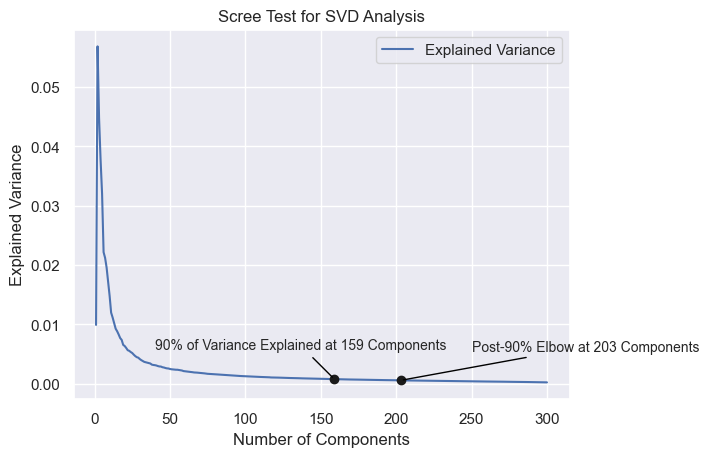

In [91]:
# Find Elbow Point
kneedle = KneeLocator(np.arange(ninety_threshold + 1, len(expl_variance)+ 1), 
                      expl_variance[ninety_threshold:], curve='convex', 
                      direction='decreasing')

elbow_location = kneedle.elbow

# Plot Elbow
sns.set_theme()

plt.plot(np.arange(1, len(expl_variance)+1),
         expl_variance[0:],
         label = "Explained Variance")

# Add Title and Axis Labels
plt.title("Scree Test for SVD Analysis")
plt.ylabel("Explained Variance")
plt.xlabel("Number of Components")
plt.legend()

# Add Annotation and Point to Show Location of 90%
plt.annotate(f"90% of Variance Explained at {ninety_threshold + 1} Components", 
             xy=(ninety_threshold + 1, expl_variance[ninety_threshold]),
             xytext=(40, (expl_variance[ninety_threshold] + 0.005)),
             arrowprops=dict(arrowstyle="-",
                             color = "black"), fontsize=10)

plt.plot(ninety_threshold + 1, expl_variance[ninety_threshold], "ko",
         label = "Elbow Point")

# Add Annotation and Point to Show Location of Elbow
plt.annotate(f"Post-90% Elbow at {elbow_location} Components", 
             xy=(elbow_location, expl_variance[elbow_location - 1]),
             xytext=(250, (expl_variance[elbow_location] + 0.005)),
             arrowprops=dict(arrowstyle="-",
                             color = "black"), fontsize=10)

plt.plot(elbow_location, expl_variance[elbow_location - 1], "ko",
         label = "Elbow Point")

Based on the elbow point, we build a content similarity dataframe.

In [90]:
# Compute the similarity matrix on the full text data
reduced_features = SVD_pipeline.transform(textual_df['full_text'])[:, :elbow_location]

# Calculate Similarity Matrix
similarity_matrix = 1 - pairwise_distances(reduced_features, metric='cosine')

content_similarity_df = pd.DataFrame(similarity_matrix, columns = textual_df.index,
                            index = textual_df.index)

#### Network-Based User Similarity

**JOEY ADD YOUR NETWORK MODEL HERE.**

#### Similarity Feature Generation

In [98]:
# Create DF for users with only 1 review and more than 1 
duplicated_user_ids = final_df[final_df.duplicated(subset=["user_id"], keep=False)]["user_id"].unique()
multi_review = final_df[final_df["user_id"].isin(duplicated_user_ids)].reset_index(drop=True)[["user_id", "app_id"]]

duplicated_user_ids = final_df[final_df.duplicated(subset=["user_id"], keep=False)]["user_id"].unique()
single_review = final_df[final_df["user_id"].isin(set(final_df["user_id"]) - set(duplicated_user_ids))]\
.reset_index(drop=True)[["user_id", "app_id"]]

In [99]:
# Find Average Similarity
def AverageSimilarityCalculator(user, game):
    
    user_ratings = multi_review[multi_review["user_id"] == user]
    other_games = user_ratings[user_ratings['app_id'] != game]
    
    other_games_titles = other_games['app_id']
    filtered_game_similarity_df = content_similarity_df.loc[game, other_games_titles] * other_games.set_index('app_id')["y"]
    
    return filtered_game_similarity_df.mean()

# Create Compiler of Avg Sim
def SimilarityGenerator(users = multi_review, 
                     similarity = content_similarity_df):
    
    similarities = []
    for i in range(0, len(users)):
        
        sim = AverageSimilarityCalculator(users.at[i, 'user_id'],
                      users.at[i, 'app_id'])
        
        similarities.append(sim)
    
    return similarities

In [102]:
# Find Most Similary User
def UserPairer(user,
              user_similarity = user_similarity_df):
    
    return user_similarity_df.loc[user].idxmax()
    
# Create Similarity Imputer
def SimilarityImputer(users = single_review):
    
    sim_list = []
    for i in range(0, len(users)):
        similar_user = UserPairer(users.at[i, "user_id"])
        
        sim = AverageSimilarityCalculator(similar_user,
                                   users.at[i, "app_id"])
        
        sim_list.append(sim_list)
    
    return sim_list

After this, we add the similarity as a column to single_review and multi_review and merge based on app_id and game_id.

### Model 2: Logistic Regression

In [40]:
# Define the columns to be dropped
columns_to_drop = ["app_id", "title", "price_original", "developer", "publisher","owners", "average_playtime", "hours"]

# Define the pipeline
l1_pipeline = Pipeline([
    ('elapsed_time', ElapsedTimeTransformer()),
    ('steam_rating', SteamRatingEncoder(standard_diverging_scale=True)),
    ('tendency_to_review', TendencyToReview(standardize = False)),
    ("target_encode", TargetEncoderTransformer(y = y_train)),
    ('interactions', InteractionsTransformer()),
    ('os_interactions', InteractionsTransformer(["win", "mac", "linux"])),
    ('drop_columns', DropColumns(columns_to_drop)),
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(penalty='l1', solver='liblinear', random_state=70))
])

# Define the grid of hyperparameters to search
param_grid = {
    'classifier__C': [0.1, 1, 10, 100],
    'classifier__class_weight': [{0: 4, 1: 1}, {0: 6, 1: 1}, {0: 8, 1: 0}]
}

# Define the grid search object
grid_search = GridSearchCV(l1_pipeline, param_grid=param_grid, cv=5)

# Fit the grid search on the data
grid_search.fit(X_train, y_train)

ValueError: 
All the 60 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/alessandromaugeri/opt/anaconda3/envs/MachineLearningTeam/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/alessandromaugeri/opt/anaconda3/envs/MachineLearningTeam/lib/python3.9/site-packages/sklearn/pipeline.py", line 401, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/Users/alessandromaugeri/opt/anaconda3/envs/MachineLearningTeam/lib/python3.9/site-packages/sklearn/pipeline.py", line 359, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/Users/alessandromaugeri/opt/anaconda3/envs/MachineLearningTeam/lib/python3.9/site-packages/joblib/memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "/Users/alessandromaugeri/opt/anaconda3/envs/MachineLearningTeam/lib/python3.9/site-packages/sklearn/pipeline.py", line 893, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "/Users/alessandromaugeri/opt/anaconda3/envs/MachineLearningTeam/lib/python3.9/site-packages/sklearn/utils/_set_output.py", line 140, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "/Users/alessandromaugeri/opt/anaconda3/envs/MachineLearningTeam/lib/python3.9/site-packages/sklearn/base.py", line 881, in fit_transform
    return self.fit(X, y, **fit_params).transform(X)
  File "/var/folders/jb/9xp08w9911z54x3w83qfzx2w0000gn/T/ipykernel_58604/3177195745.py", line 15, in fit
    self.encoder_dis.fit(X["publisher"].reset_index(drop = True), self.y.reset_index(drop = True))
  File "/Users/alessandromaugeri/opt/anaconda3/envs/MachineLearningTeam/lib/python3.9/site-packages/category_encoders/utils.py", line 294, in fit
    X, y = convert_inputs(X, y)
  File "/Users/alessandromaugeri/opt/anaconda3/envs/MachineLearningTeam/lib/python3.9/site-packages/category_encoders/utils.py", line 82, in convert_inputs
    if any(X.index != y.index):
  File "/Users/alessandromaugeri/opt/anaconda3/envs/MachineLearningTeam/lib/python3.9/site-packages/pandas/core/ops/common.py", line 81, in new_method
    return method(self, other)
  File "/Users/alessandromaugeri/opt/anaconda3/envs/MachineLearningTeam/lib/python3.9/site-packages/pandas/core/arraylike.py", line 44, in __ne__
    return self._cmp_method(other, operator.ne)
  File "/Users/alessandromaugeri/opt/anaconda3/envs/MachineLearningTeam/lib/python3.9/site-packages/pandas/core/indexes/range.py", line 964, in _cmp_method
    return super()._cmp_method(other, op)
  File "/Users/alessandromaugeri/opt/anaconda3/envs/MachineLearningTeam/lib/python3.9/site-packages/pandas/core/indexes/base.py", line 6758, in _cmp_method
    raise ValueError("Lengths must match to compare")
ValueError: Lengths must match to compare


### Model 3: Decision Tree

## Model Evaluation

### Creating New Features

**Comparison of mean playtime and median playtime in terms of skewness MOVE THIS UP**

We compare mean and median playtime in terms of skewness to gain a better understanding of the distribution of the 'hours' column. This helps use to decide whether to use the mean or median for further analysis.

Number of outliers in 'hours' column: 37
Skewness of 'hours' column: 2.431246757507324
The 'hours' column is highly skewed. It is recommended to use the median for further analysis.


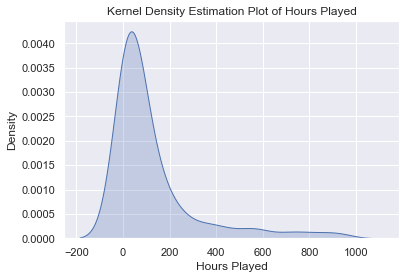

In [42]:
# skewness of the 'hours' column


# Step 1: Assess the distribution of the 'hours' column
skewness = final_df['hours'].skew()

# Step 2: Use a for loop to identify outliers (using the IQR method)
Q1 = final_df['hours'].quantile(0.25)
Q3 = final_df['hours'].quantile(0.75)
IQR = Q3 - Q1

outliers = []
for hours in final_df['hours']:
    if (hours < (Q1 - 1.5 * IQR)) or (hours > (Q3 + 1.5 * IQR)):
        outliers.append(hours)

# Print the number of outliers and skewness value
print(f"Number of outliers in 'hours' column: {len(outliers)}")
print(f"Skewness of 'hours' column: {skewness}")

# Step 3: Decide whether to use the median or the mean for further analysis
if skewness > 1 or skewness < -1:
    print("The 'hours' column is highly skewed. It is recommended to use the median for further analysis.")
else:
    print("The 'hours' column is not highly skewed. It is recommended to use the mean for further analysis.")


# Create a kernel density estimation plot for the 'hours' column
sns.kdeplot(final_df['hours'], shade=True)

# Add labels and title
plt.xlabel('Hours Played')
plt.ylabel('Density')
plt.title('Kernel Density Estimation Plot of Hours Played')

# Show the plot
plt.show()

There are 119,793 data points in the 'hours' column that are considered outliers, based on the Interquartile Range (IQR) method. These data points lie outside the typical range of values, and they might have a significant impact on the mean and standard deviation.

The 'hours' column is highly skewed - The skewness of the 'hours' column is either greater than 1, indicating that the distribution is not symmetric and has a significant tail on one side. In this case, the tail is likely on the right side, meaning that there are a few games with extremely high playtimes compared to the majority. 

Given these results, it is recommended to use the median instead of the mean for further analysis of the 'hours' column. The median is less sensitive to outliers and provides a more accurate representation of the central tendency of the data. By using the median, you can mitigate the impact of extreme values and better understand the typical playtime for games in the dataset.

## Additional Data Exploration after Feature Engeneering

**Exploration of elapsed time**

By analyzing the elapsed time, we can gain a better understanding about when users are most likely to write reviews, whether they tend to review games soon after release or after a significant amount of time has passed.

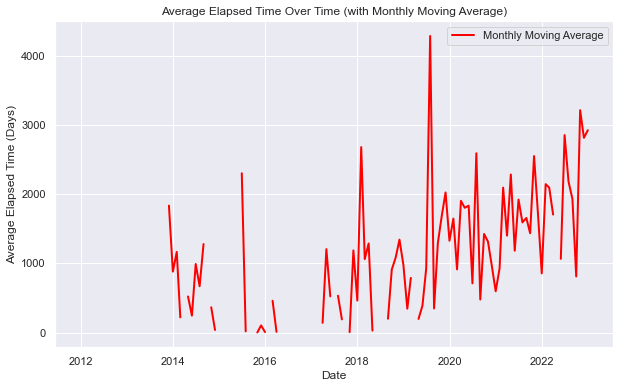

In [43]:
# Filter out rows with negative elapsed time
final_df = final_df[final_df['elapsed_time'].dt.days >= 0]

# Calculate the average 'elapsed_time_days' for each unique review date
average_elapsed_time = final_df.groupby('date')['elapsed_time'].mean().reset_index()

# Set the 'date' column as the index
average_elapsed_time.set_index('date', inplace=True)

# Convert the elapsed time to days
average_elapsed_time['elapsed_time'] = average_elapsed_time['elapsed_time'].dt.days

# Resample the data to a monthly frequency and calculate the moving average
monthly_moving_average = average_elapsed_time.resample('M').mean().rolling(window=1).mean()

# Plot the average 'elapsed_time_days' and the monthly moving average over time
plt.figure(figsize=(10, 6))
#plt.plot(average_elapsed_time, label='Average Elapsed Time (Days)')
plt.plot(monthly_moving_average, label='Monthly Moving Average', linewidth=2, color='red')
plt.xlabel('Date')
plt.ylabel('Average Elapsed Time (Days)')
plt.title('Average Elapsed Time Over Time (with Monthly Moving Average)')
plt.legend()
plt.show()


The plot shows that the average elapsed time increases on average from 2012 to 2022.

One possible reason for the increase in the average elapsed time over the years could be the increase in the number of games being released on the Steam platform over time.

As the number of games being released increases, the number of reviews being posted for each game is also likely to increase, leading to a larger number of reviews for games that have been released more recently. This, in turn, could lead to a higher average elapsed time for reviews, as more recent games would have less time for reviews to be posted compared to older games.

Additionally, as the number of games on the platform increases, the average age of games being reviewed is likely to decrease. Newer games are more likely to be reviewed closer to their release date than older games, which may also contribute to the increase in the average elapsed time for reviews.

In [44]:
unique_discounts = final_df['discount'].unique()
print(unique_discounts)

[ 0. 90. 75. 60. 50. 85. 80. 65. 66. 67. 84.]


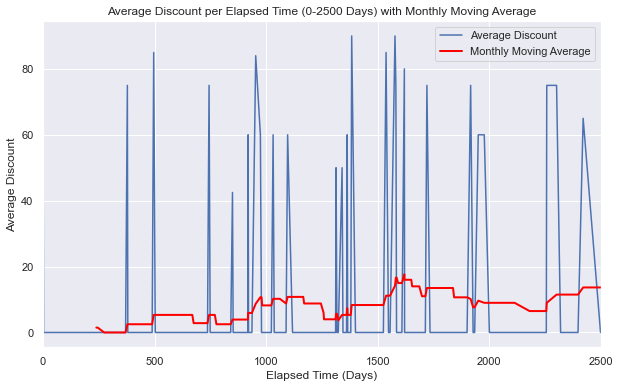

In [45]:
# Filter out rows with negative elapsed time and limit the range to 0-2500 days
final_df = final_df[(final_df['elapsed_time'].dt.days >= 0) & (final_df['elapsed_time'].dt.days <= 2500)]

# Convert the elapsed time to days
final_df['elapsed_time_days'] = final_df['elapsed_time'].dt.days

# Group by 'elapsed_time_days' and calculate the mean discount for each group
average_discount_per_elapsed_time = final_df.groupby('elapsed_time_days')['discount'].mean().reset_index()

# Set the 'elapsed_time_days' column as the index
average_discount_per_elapsed_time.set_index('elapsed_time_days', inplace=True)

# Calculate the moving average using a rolling window of approximately 30 days
monthly_moving_average = average_discount_per_elapsed_time.rolling(window=30).mean()

# Create the line plot with the monthly moving average
plt.figure(figsize=(10, 6))
plt.plot(average_discount_per_elapsed_time, label='Average Discount')
plt.plot(monthly_moving_average, label='Monthly Moving Average', linewidth=2, color='red')
plt.xlabel('Elapsed Time (Days)')
plt.ylabel('Average Discount')
plt.title('Average Discount per Elapsed Time (0-2500 Days) with Monthly Moving Average')
plt.xlim(0, 2500)
plt.legend()
plt.show()


The plot shows that as the elaplsed time increases, the average discount also increases. This is what we would have expected. However, from an elapsed time of 1300 days, the average discount is relatively stable.

**Exploration of review tendency**

In [46]:
print(final_df['review_tendency'].describe())
print("")
print(final_df['rel_review_tendency'].describe())

count    235.000000
mean       0.061888
std        0.206546
min        0.000404
25%        0.011800
50%        0.023622
75%        0.050890
max        3.000000
Name: review_tendency, dtype: float64

count    235.000000
mean       1.576771
std        8.599814
min       -0.983198
25%       -0.508711
50%       -0.016464
75%        1.118868
max      123.909091
Name: rel_review_tendency, dtype: float64


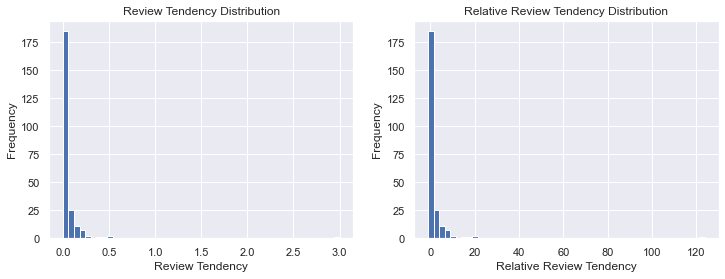

In [47]:
# Create a figure with two subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Create a histogram of review_tendency variable in the first subplot
axes[0].hist(final_df["review_tendency"], bins=50)
axes[0].set_title("Review Tendency Distribution")
axes[0].set_xlabel("Review Tendency")
axes[0].set_ylabel("Frequency")

# Create a histogram of rel_review_tendency variable in the second subplot
axes[1].hist(final_df["rel_review_tendency"], bins=50)
axes[1].set_title("Relative Review Tendency Distribution")
axes[1].set_xlabel("Relative Review Tendency")
axes[1].set_ylabel("Frequency")

# Show the plots
plt.show()

The distribution of the variable review_tendency suggests that users tend to review a relatively small number of games. The mean value of 0.054 and the median value of 0.027 indicate that on average, users leave a review for only a small fraction of the games they own. Moreover, we need to take into account that every user recorded in the dataset has left at least one review. This suggests that the value of tendency to review calculated on the whole population would be considerely lower.

We can assume, as a consequence, that users only review games when they have a strong opinion about it. We check, then, if and how the tendency to review influences the review score.

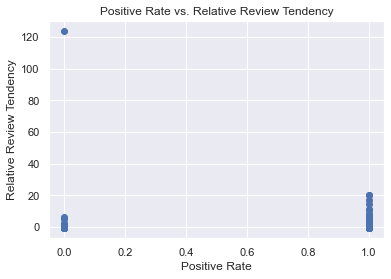

In [48]:
# Create a scatter plot of positive_rate vs rel_review_tendency
plt.scatter(final_df['positive_rate'], final_df['rel_review_tendency'])

# Set the title and axis labels
plt.title("Positive Rate vs. Relative Review Tendency")
plt.xlabel("Positive Rate")
plt.ylabel("Relative Review Tendency")

# Show the plot
plt.show()

NEED TO COMMENT ON THIS ONE

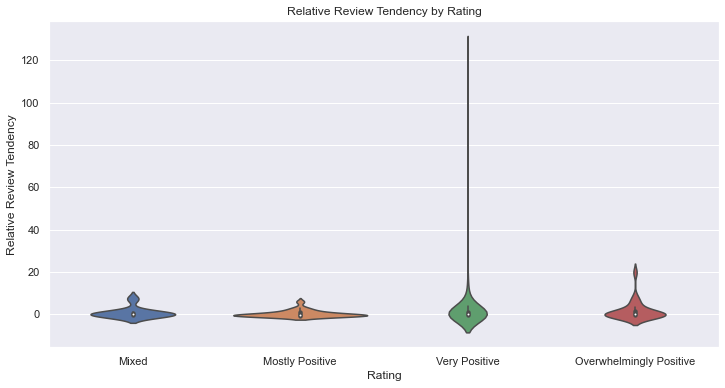

In [49]:
# Create a violin plot of review_tendency for each category of rating
plt.figure(figsize=(12,6))
ordered_categories = ['Mixed', 'Mostly Positive', 'Very Positive', 'Overwhelmingly Positive'] 
sns.violinplot(x="rating", y="rel_review_tendency", data=final_df, order=ordered_categories)

# Set the title and axis labels
plt.title("Relative Review Tendency by Rating")
plt.xlabel("Rating")
plt.ylabel("Relative Review Tendency")

# Show the plot
plt.show()

Comparing users' relative tendency to review to the rating they gave to the games, we notice how the higher is the tendency to review, the higher the scores given.

One possible explanation for this phenomenon is that users who are more active in reviewing games may have a stronger interest and engagement with the gaming community, and are therefore more likely to enjoy the games they play and give them higher ratings.

Alternatively, it could be that users who have a more positive overall attitude towards games are more likely to review them and give them higher ratings, while users who are more critical or have a negative bias may not review games as often or may be more likely to give lower ratings.

## Correlation
Since the variable 'y' is binary, and the dataset is composed of categorical, binary and continuous variable, we calculated the correlations with different coefficients.

#### Continuous Variables
To calculate the correlation between "y" and continous variables, we use the point-biserial correlation coefficient. The point-biserial correlation coefficient measures the strength and direction of the association between a binary variable and a continuous variable.

The point-biserial correlation coefficient assumes that the binary variable is dichotomous, meaning it has only two possible values (in our case, 0 or 1), and that the continuous variable is normally distributed.

The point-biserial correlation is based on three assumptions: 
1. No outliers (continuous variable) - assessed through a visual examination of the scatterplot
2. Approximately normally distributed continuous variable
3. Homogeneity of variance of the continuous variable between both groups of the dichotomous variable

In [51]:
# Define the numeric variables
num_variables = ['price_final', 'positive_ratio', 'hours', 'median_playtime', 'user_reviews',
                'price_original', 'discount', 'products', 'reviews',
                'elapsed_time_days', 'review_count']

Check that the variables meet the requirements for the point-biserial correlation.

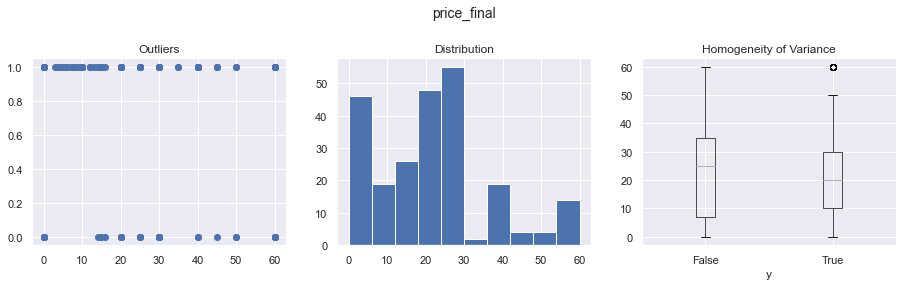

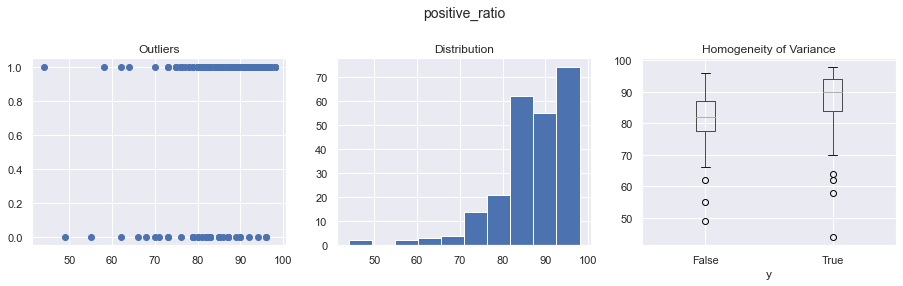

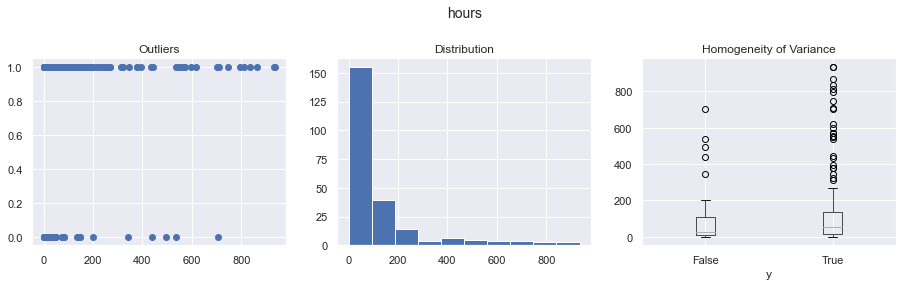

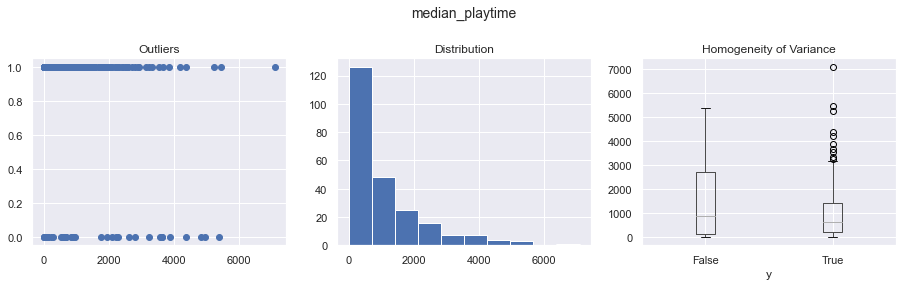

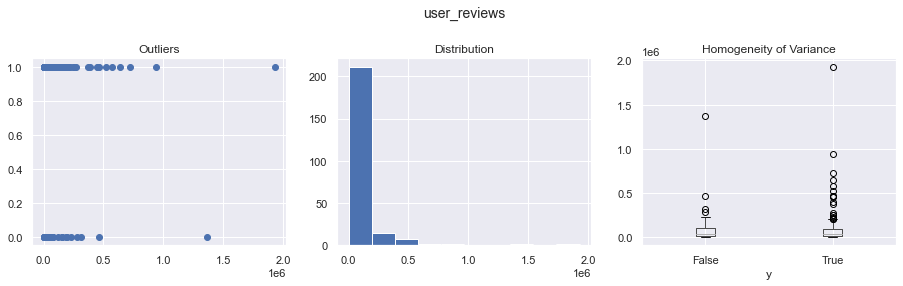

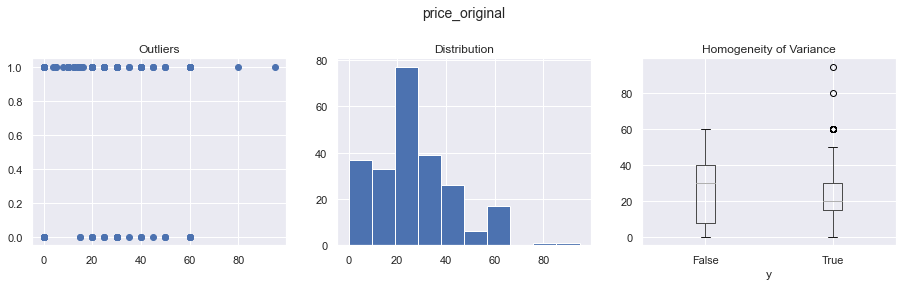

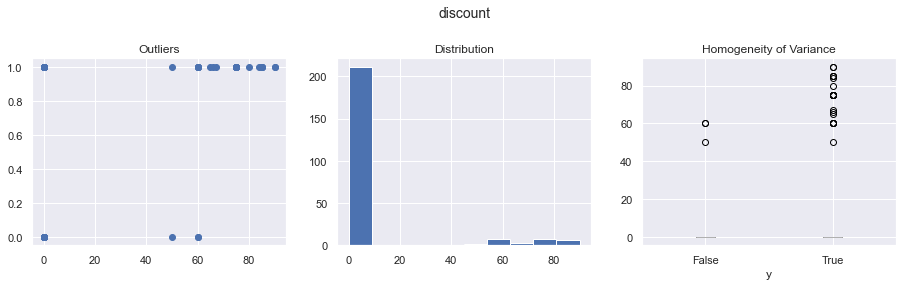

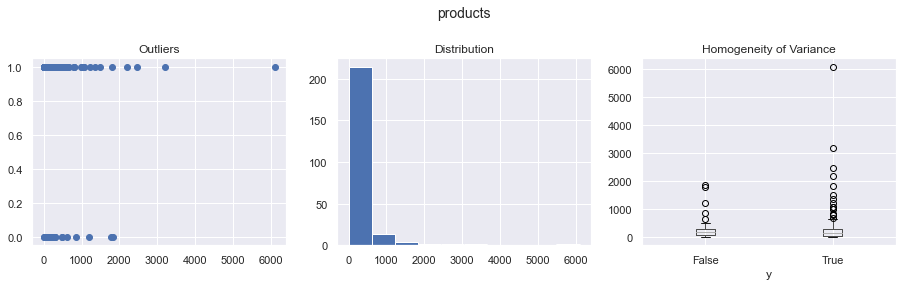

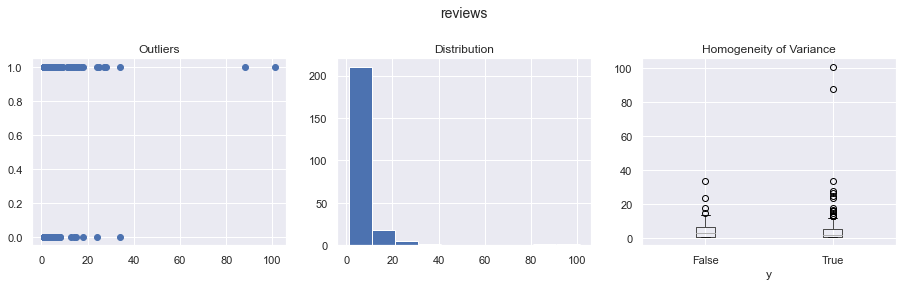

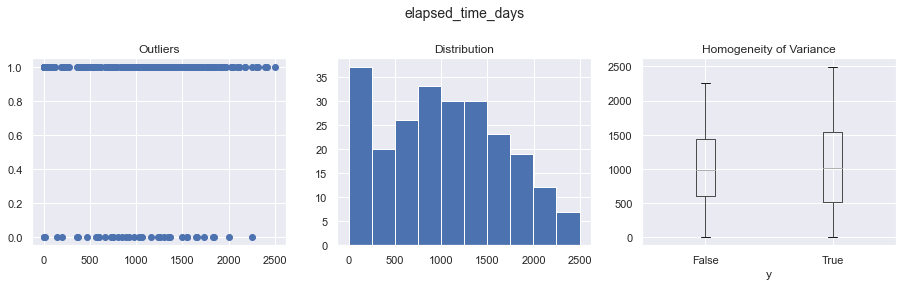

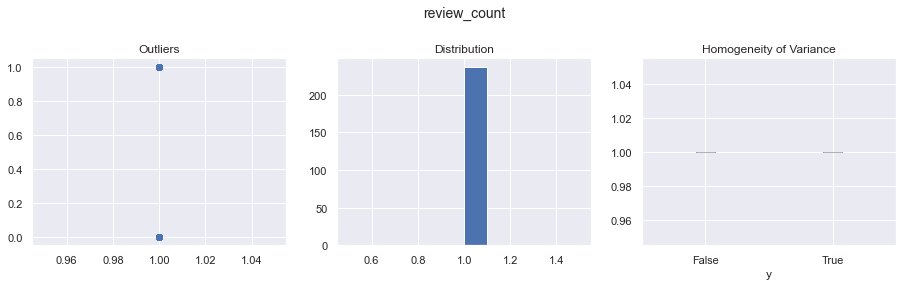

In [52]:
# loop through the numeric variables
def check_req(df, variable_list):
    for var in variable_list:
        fig, axs = plt.subplots(1, 3, figsize=(15, 4))

        # Check for outliers with a scatterplot
        axs[0].scatter(df[var], final_df['y'])
        axs[0].set_title("Outliers")

        # Check for normal distribution with a histogram
        axs[1].hist(df[var])
        axs[1].set_title("Distribution")

        # Check for homogeneity of variance with a boxplot
        df.boxplot(column=var, by='y', ax=axs[2])
        axs[2].set_title("Homogeneity of Variance")

        # Set overall title
        plt.suptitle(var, fontsize=14)
        fig.subplots_adjust(top=0.8)

        plt.show()
        
check_req(final_df, num_variables)

In [53]:
# Create a new DataFrame to store the normalized variables
final_df_log = pd.DataFrame()

var_to_norm = ['hours', 'median_playtime', 'user_reviews',
                'products', 'reviews',
                'elapsed_time_days', 'review_count']

# Loop over the variables and apply log transformation to each one
for col in var_to_norm:
    final_df_log[col] = np.log(final_df[col] + 0.0001)
    
final_df_norm = pd.concat([final_df.drop(var_to_norm, axis=1), final_df_log], axis=1)

In [55]:
# Calculate correlation based on the normalized dataset 
cor_matrix = []

for variable in num_variables:
    r_pb, p_value = pointbiserialr(final_df_norm['y'], final_df_norm[variable])
    cor_matrix.append({'Variable name': variable, 'corr': r_pb, 'p-value': p_value})

cor_df = pd.DataFrame(cor_matrix)
cor_df['corr'] = abs(cor_df['corr'])
display(cor_df.sort_values(by="corr", ascending = False))

C:\Users\utente\anaconda3\lib\site-packages\scipy\stats\stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


,Variable name,corr,p-value
1,positive_ratio,0.340163,7.871603e-08
2,hours,0.121829,6.112437e-02
0,price_final,0.089138,1.713970e-01
8,reviews,0.074783,2.514662e-01
6,discount,0.067415,3.013535e-01
4,user_reviews,0.066769,3.060223e-01
3,median_playtime,0.066570,3.074721e-01
5,price_original,0.053559,4.117830e-01
9,elapsed_time_days,0.027468,6.739669e-01
7,products,0.007924,9.034149e-01


Making the correlation coefficient absolute, we can state the the variables more with a stronger correlation to y are positive_ratio and hours. The ones that follow in the dataset are still correlated (all the p-values are <0.5), but with coefficients lower than 10%.

In any case, we notice that the correlations are not strong across all the variables, with values that don't go over 25%.

#### Binary variables
Phi is a measure for the strength of an association between two categorical variables in a 2 × 2 contingency table. It is calculated by taking the chi-square value, dividing it by the sample size, and then taking the square root of this value. It varies between 0 and 1 without any negative values.

In [56]:
# Define binary variables
bin_variables = ['mac', 'linux']

In [57]:
# Check that they all have two different values
for var in bin_variables: 
    print(var, final_df[var].unique())

mac [False  True]
linux [False  True]


In [58]:
# Calculate their phi value and its p-value
warnings.filterwarnings("ignore", category=FutureWarning)

phi_df = pd.DataFrame(columns=['Variable name', 'corr', 'p-value'])

for var in bin_variables:
    contingency = pd.crosstab(final_df['y'], final_df[var])
    ChiSqResult = chi2_contingency(contingency)
    n = contingency.values.sum()
    phi = np.sqrt(ChiSqResult[0] / n)
    p_value = ChiSqResult[1]
    
    phi_df = phi_df.append({'Variable name': var, 'corr': phi, 'p-value': p_value}, ignore_index=True)

display(phi_df)

,Variable name,corr,p-value
0,mac,0.169165,0.009207
1,linux,0.103931,0.1096


#### Categorical variables
Cramer's V is an alternative to phi in tables bigger than 2 × 2 tabulation. Cramer's V varies between 0 and 1 without any negative values. Similar to Pearson's r, a value close to 0 means no association. However, a value bigger than 0.25 is named as a very strong relationship for the Cramer's V.

In [59]:
# Define categorical variables
cat_variables = ['rating', 'developer', 'publisher', 'achievements']

In [60]:
# Check that they all have more than two different values
for var in cat_variables: 
    print(var, final_df[var].nunique())

rating 4
developer 208
publisher 167
achievements 99


In [61]:
# calculate Cramer V coefficient for each variable and y
results = []
for var in cat_variables:
    contingency = pd.crosstab(final_df['y'], final_df[var])
    chi2 = chi2_contingency(contingency)[0]
    N = len(final_df)
    minimum_dimension = (min(contingency.shape)-1)
    result = np.sqrt((chi2/N) / minimum_dimension)
    p_value = chi2_contingency(contingency)[1]
    results.append({'Variable name': var, 'corr': result, 'p-value': p_value})

# create dataframe with results
results_df = pd.DataFrame(results).sort_values(by='corr', ascending=False)

display(results_df)

,Variable name,corr,p-value
1,developer,0.932503,0.504869
2,publisher,0.845993,0.407535
3,achievements,0.668371,0.275830
0,rating,0.309286,0.000047
